In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

import pandas as pd
import os
import cv2

from sklearn.model_selection import train_test_split

In [3]:
def load_annotations(csv_file):
    return pd.read_csv(csv_file)

def create_mask(row, image_shape):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    for _, r in row.iterrows():
        xmin, ymin, xmax, ymax = r['xmin'], r['ymin'], r['xmax'], r['ymax']
        label = 1 if r['label'] == 'rbc' else 2  # 1 for RBC, 2 for WBC
        mask[int(ymin):int(ymax), int(xmin):int(xmax)] = label
    return mask


def preprocess_data(annotations, base_path='rbc_wbc_unet/images'):
    images = []
    masks = []
    for image_file in annotations['image'].unique():
        full_path = os.path.join(base_path, image_file)

        if not os.path.exists(full_path):
            print(f"Image file {full_path} not found.")
            continue

        img = load_img(full_path, color_mode='rgb')
        img = img_to_array(img)
        img = cv2.resize(img, (256, 256))
        images.append(img)

        mask = create_mask(annotations[annotations['image'] == image_file], img.shape)
        masks.append(mask)

    images = np.array(images, dtype='float32') / 255.0
    masks = np.array(masks)
    masks = to_categorical(masks, num_classes=3)  # 3 classes: background, RBC, WBC

    return train_test_split(images, masks, test_size=0.2, random_state=42)

In [4]:

def build_unet_model(input_shape):
    inputs = Input(input_shape)

    # Downsampling
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)

    # Upsampling
    up7 = concatenate([UpSampling2D(size=(2, 2))(drop4), conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(3, 1, activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    return model

In [5]:
annotations = load_annotations('rbc_wbc_unet/annotations.csv')
X_train, X_val, y_train, y_val = preprocess_data(annotations)

unet_model = build_unet_model((256, 256, 3))
unet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

# Train, evaluate, visualize the model
history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)
val_loss, val_accuracy = unet_model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.2743 - loss: 1.4462 
Epoch 1: val_loss improved from None to 0.98504, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 51s 15s/step - accuracy: 0.3326 - loss: 2.1801 - val_accuracy: 0.6687 - val_loss: 0.9850
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5083 - loss: 1.0187 
Epoch 2: val_loss did not improve from 0.98504
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 14s/step - accuracy: 0.4067 - loss: 1.0306 - val_accuracy: 0.2452 - val_loss: 1.0410
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.2463 - loss: 1.0438 
Epoch 3: val_loss did not improve from 0.98504
3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.2417 - loss: 1.0412 - val_accuracy: 0.2455 - val_loss: 0.9912
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.2833 - loss: 0.9991 
Epoch 4: val_loss improved from 0.98504 to 0.90598, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 15s/step - accuracy: 0.3457 - loss: 0.9937 - val_accuracy: 0.6564 - val_loss: 0.9060
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6432 - loss: 0.9346 
Epoch 5: val_loss improved from 0.90598 to 0.85686, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 14s/step - accuracy: 0.6343 - loss: 0.9371 - val_accuracy: 0.6562 - val_loss: 0.8569
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6355 - loss: 0.8967 
Epoch 6: val_loss improved from 0.85686 to 0.76842, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.6343 - loss: 0.8867 - val_accuracy: 0.6562 - val_loss: 0.7684
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6362 - loss: 0.7907 
Epoch 7: val_loss improved from 0.76842 to 0.62981, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 14s/step - accuracy: 0.6343 - loss: 0.7717 - val_accuracy: 0.6562 - val_loss: 0.6298
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6375 - loss: 0.6814 
Epoch 8: val_loss improved from 0.62981 to 0.56998, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.6343 - loss: 0.6787 - val_accuracy: 0.6562 - val_loss: 0.5700
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6345 - loss: 0.6141 
Epoch 9: val_loss improved from 0.56998 to 0.54398, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.6343 - loss: 0.6137 - val_accuracy: 0.6562 - val_loss: 0.5440
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6896 - loss: 0.5844 
Epoch 10: val_loss improved from 0.54398 to 0.53615, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 14s/step - accuracy: 0.7267 - loss: 0.5805 - val_accuracy: 0.7972 - val_loss: 0.5361
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7817 - loss: 0.5585 
Epoch 11: val_loss improved from 0.53615 to 0.48953, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.7827 - loss: 0.5578 - val_accuracy: 0.8157 - val_loss: 0.4895
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7895 - loss: 0.5384 
Epoch 12: val_loss improved from 0.48953 to 0.47324, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.7894 - loss: 0.5329 - val_accuracy: 0.8138 - val_loss: 0.4732
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7923 - loss: 0.5122 
Epoch 13: val_loss improved from 0.47324 to 0.45821, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 44s 14s/step - accuracy: 0.7932 - loss: 0.5138 - val_accuracy: 0.8141 - val_loss: 0.4582
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7873 - loss: 0.5090 
Epoch 14: val_loss improved from 0.45821 to 0.44834, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.7890 - loss: 0.5072 - val_accuracy: 0.8169 - val_loss: 0.4483
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7927 - loss: 0.4969 
Epoch 15: val_loss improved from 0.44834 to 0.43946, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 15s/step - accuracy: 0.7942 - loss: 0.4938 - val_accuracy: 0.8190 - val_loss: 0.4395
Epoch 16/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7959 - loss: 0.4830 
Epoch 16: val_loss improved from 0.43946 to 0.43103, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.7944 - loss: 0.4851 - val_accuracy: 0.8204 - val_loss: 0.4310
Epoch 17/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7969 - loss: 0.4728 
Epoch 17: val_loss improved from 0.43103 to 0.42618, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.7954 - loss: 0.4738 - val_accuracy: 0.8185 - val_loss: 0.4262
Epoch 18/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7967 - loss: 0.4664 
Epoch 18: val_loss improved from 0.42618 to 0.42296, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.7955 - loss: 0.4665 - val_accuracy: 0.8178 - val_loss: 0.4230
Epoch 19/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7966 - loss: 0.4623 
Epoch 19: val_loss improved from 0.42296 to 0.40797, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 14s/step - accuracy: 0.7957 - loss: 0.4587 - val_accuracy: 0.8267 - val_loss: 0.4080
Epoch 20/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8060 - loss: 0.4536 
Epoch 20: val_loss did not improve from 0.40797
3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 13s/step - accuracy: 0.8050 - loss: 0.4620 - val_accuracy: 0.8409 - val_loss: 0.4147
Epoch 21/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8130 - loss: 0.4627 
Epoch 21: val_loss improved from 0.40797 to 0.40274, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.8187 - loss: 0.4519 - val_accuracy: 0.8438 - val_loss: 0.4027
Epoch 22/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8206 - loss: 0.4461 
Epoch 22: val_loss improved from 0.40274 to 0.39606, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 15s/step - accuracy: 0.8250 - loss: 0.4406 - val_accuracy: 0.8525 - val_loss: 0.3961
Epoch 23/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8370 - loss: 0.4272 
Epoch 23: val_loss improved from 0.39606 to 0.37578, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.8355 - loss: 0.4301 - val_accuracy: 0.8675 - val_loss: 0.3758
Epoch 24/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8549 - loss: 0.3979 
Epoch 24: val_loss improved from 0.37578 to 0.37015, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 14s/step - accuracy: 0.8527 - loss: 0.4082 - val_accuracy: 0.8816 - val_loss: 0.3701
Epoch 25/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8668 - loss: 0.4110 
Epoch 25: val_loss improved from 0.37015 to 0.36241, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.8693 - loss: 0.4026 - val_accuracy: 0.8792 - val_loss: 0.3624
Epoch 26/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8624 - loss: 0.4203 
Epoch 26: val_loss did not improve from 0.36241
3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.8657 - loss: 0.4184 - val_accuracy: 0.8846 - val_loss: 0.3626
Epoch 27/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8646 - loss: 0.4140 
Epoch 27: val_loss did not improve from 0.36241
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 14s/step - accuracy: 0.8636 - loss: 0.4080 - val_accuracy: 0.8836 - val_loss: 0.3722
Epoch 28/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8695 - loss: 0.3847 
Epoch 28: val_loss improved from 0.36241 to 0.31768, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.8714 - loss: 0.3793 - val_accuracy: 0.8892 - val_loss: 0.3177
Epoch 29/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8806 - loss: 0.3576 
Epoch 29: val_loss did not improve from 0.31768
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 14s/step - accuracy: 0.8850 - loss: 0.3432 - val_accuracy: 0.8922 - val_loss: 0.3423
Epoch 30/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8749 - loss: 0.3921 
Epoch 30: val_loss improved from 0.31768 to 0.31128, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.8721 - loss: 0.3845 - val_accuracy: 0.8952 - val_loss: 0.3113
Epoch 31/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8860 - loss: 0.3512 
Epoch 31: val_loss did not improve from 0.31128
3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 15s/step - accuracy: 0.8815 - loss: 0.3581 - val_accuracy: 0.8804 - val_loss: 0.3377
Epoch 32/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8750 - loss: 0.3599 
Epoch 32: val_loss did not improve from 0.31128
3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 13s/step - accuracy: 0.8679 - loss: 0.3855 - val_accuracy: 0.8900 - val_loss: 0.3197
Epoch 33/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8611 - loss: 0.3842 
Epoch 33: val_loss improved from 0.31128 to 0.30439, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 14s/step - accuracy: 0.8569 - loss: 0.3878 - val_accuracy: 0.8987 - val_loss: 0.3044
Epoch 34/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8853 - loss: 0.3399 
Epoch 34: val_loss did not improve from 0.30439
3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 13s/step - accuracy: 0.8815 - loss: 0.3447 - val_accuracy: 0.8924 - val_loss: 0.3140
Epoch 35/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8913 - loss: 0.3163 
Epoch 35: val_loss improved from 0.30439 to 0.28037, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 13s/step - accuracy: 0.8894 - loss: 0.3207 - val_accuracy: 0.9029 - val_loss: 0.2804
Epoch 36/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9003 - loss: 0.3030 
Epoch 36: val_loss did not improve from 0.28037
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 14s/step - accuracy: 0.9026 - loss: 0.2931 - val_accuracy: 0.9010 - val_loss: 0.3023
Epoch 37/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9067 - loss: 0.2687 
Epoch 37: val_loss improved from 0.28037 to 0.27003, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.9059 - loss: 0.2682 - val_accuracy: 0.9058 - val_loss: 0.2700
Epoch 38/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9052 - loss: 0.2610 
Epoch 38: val_loss did not improve from 0.27003
3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.9059 - loss: 0.2592 - val_accuracy: 0.9017 - val_loss: 0.2727
Epoch 39/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9040 - loss: 0.2627 
Epoch 39: val_loss improved from 0.27003 to 0.25299, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 14s/step - accuracy: 0.9074 - loss: 0.2529 - val_accuracy: 0.9088 - val_loss: 0.2530
Epoch 40/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9088 - loss: 0.2497 
Epoch 40: val_loss improved from 0.25299 to 0.24624, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 15s/step - accuracy: 0.9094 - loss: 0.2457 - val_accuracy: 0.9110 - val_loss: 0.2462
Epoch 41/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9116 - loss: 0.2410 
Epoch 41: val_loss improved from 0.24624 to 0.23832, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.9133 - loss: 0.2364 - val_accuracy: 0.9142 - val_loss: 0.2383
Epoch 42/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9146 - loss: 0.2330 
Epoch 42: val_loss did not improve from 0.23832
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 14s/step - accuracy: 0.9155 - loss: 0.2278 - val_accuracy: 0.9137 - val_loss: 0.2476
Epoch 43/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9159 - loss: 0.2279 
Epoch 43: val_loss did not improve from 0.23832
3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 14s/step - accuracy: 0.9165 - loss: 0.2224 - val_accuracy: 0.9160 - val_loss: 0.2395
Epoch 44/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9185 - loss: 0.2157 
Epoch 44: val_loss did not improve from 0.23832
3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 15s/step - accuracy: 0.9190 - loss: 0.2151 - val_accuracy: 0.9151 - val_loss: 0.2496
Epoch 45/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9217 - loss: 0.2044 
Epoch 45: val_loss did not improve from 0.23832
3/3 ━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.9240 - loss: 0.2011 - val_accuracy: 0.9169 - val_loss: 0.2316
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9169 - loss: 0.2316
Validation Loss: 0.23155078291893005, Validation Accuracy: 0.916851818561554


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


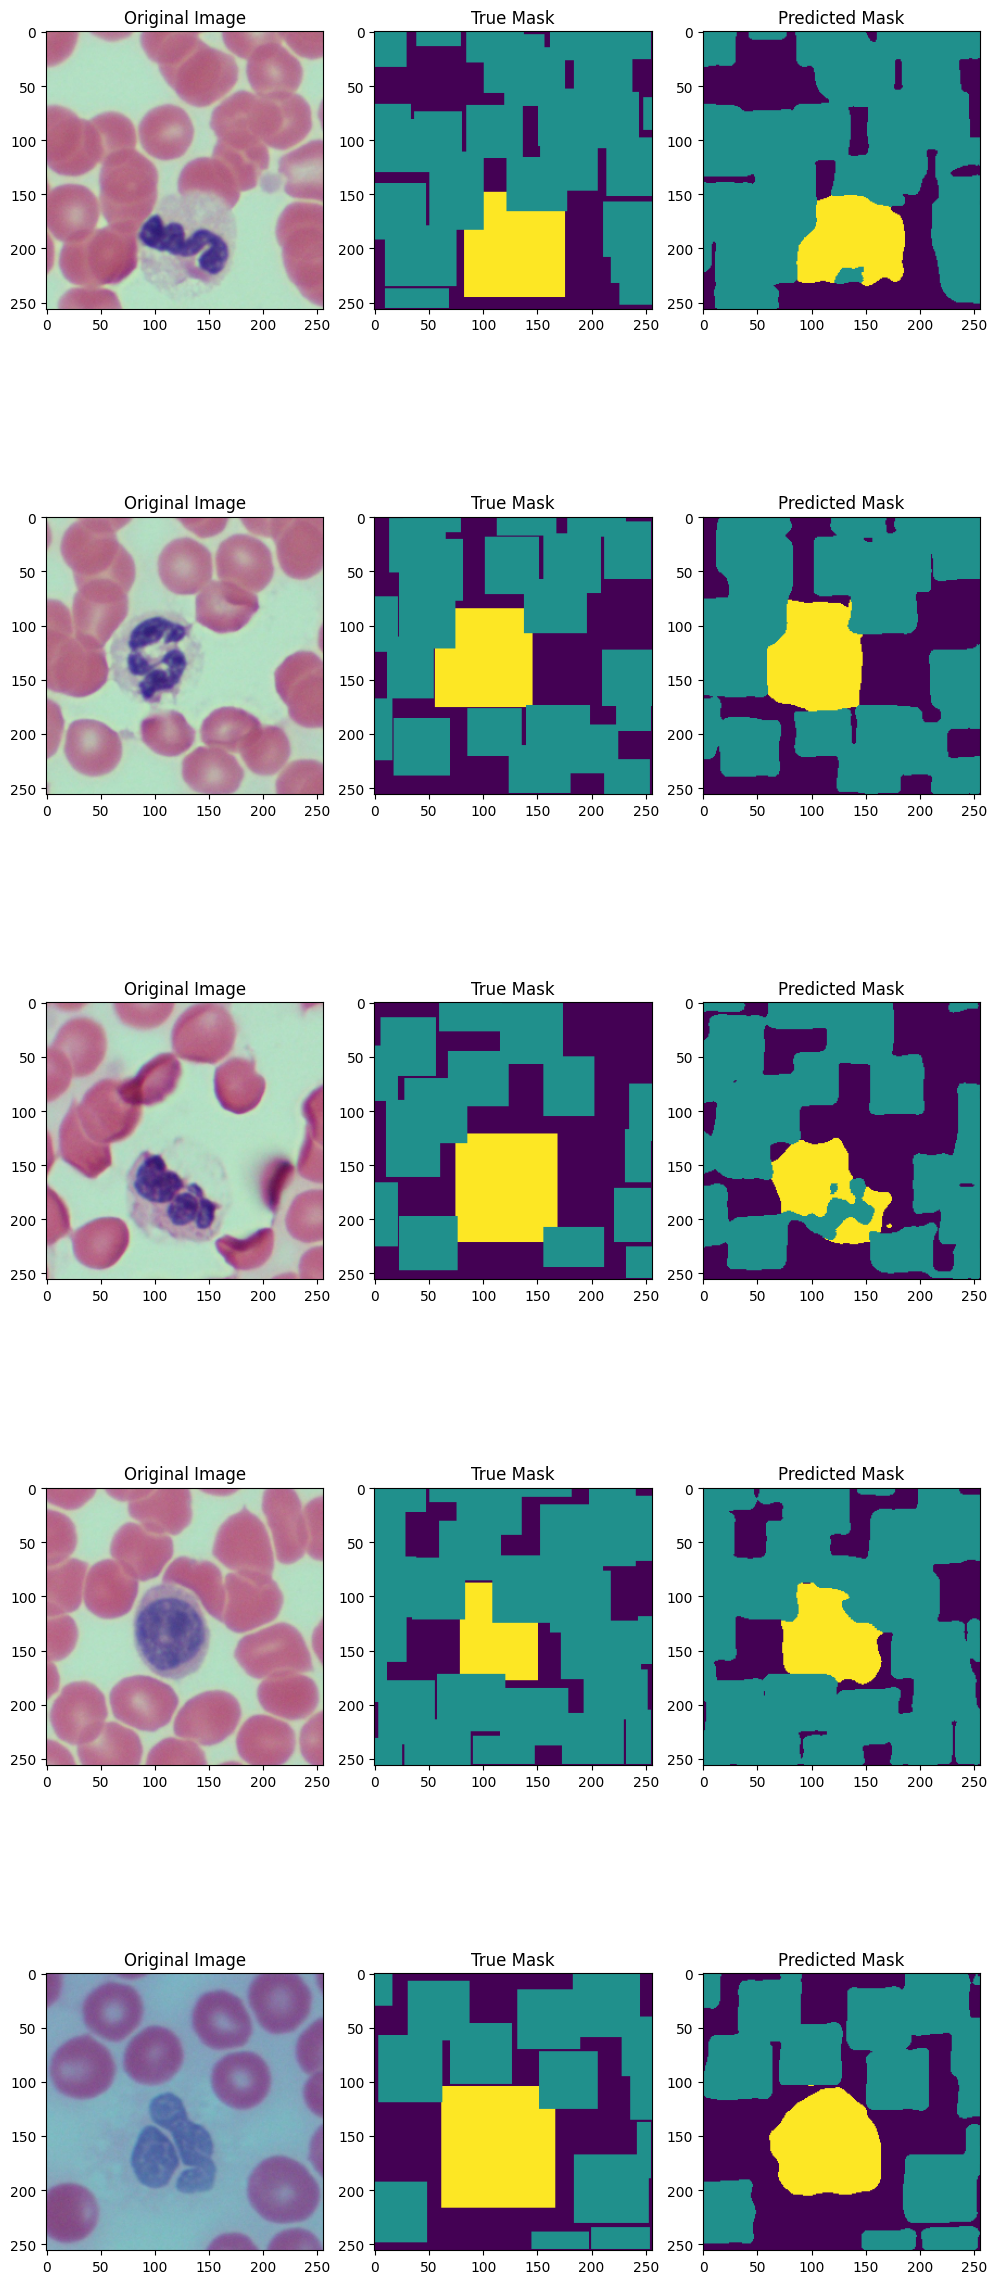

In [6]:
def visualize_predictions(images, masks, model, num_images=5):
    plt.figure(figsize=(10, num_images * 5))
    for i in range(num_images):
        img = images[i]
        true_mask = masks[i]
        predicted_mask = model.predict(np.expand_dims(img, axis=0))
        predicted_mask = np.argmax(predicted_mask, axis=-1)[0, :, :]

        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title("Original Image")

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(np.argmax(true_mask, axis=-1))
        plt.title("True Mask")

        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predicted_mask)
        plt.title("Predicted Mask")

    plt.tight_layout()
    plt.show()

visualize_predictions(X_val, y_val, unet_model, num_images=5)